Assuming the dimension of some region and its adjacent regions remain the same, check how increasing region count affects convergence.

1. Start with 3 regions. Consider innermost region. Add regions to its right.
2. Start with 3 regions. Consider outermost body region. Add regions to its left.
3. Start with 3 regions. Consider middle region. Compute with varying numbers of regions on either side.

In [ ]:
import math
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.relpath('../../'))
sys.path.append(os.path.relpath('../'))
from helpers import *

In [2]:
class LargeConvergenceProblem(ConvergenceProblemI):
  # We only care for the [error] convergence point (am, dp), do not need intermediate values.
  # This will reduce matrix solves since the matrices get large for many-regions.
  
  def find_convergence_point(self, all_a_matrices, all_b_vectors, all_c_vectors, particular_contribution,
                             nmk_max, omega, data_dict, error = 0.01):
    true_am, true_dp = data_dict["am"], data_dict["dp"]
    am_bools, dp_bools = [None for i in range(nmk_max)], [None for i in range(nmk_max)]

    def calculate_hydros(nmk):
      x = self.get_unknown_coeffs(all_a_matrices[nmk - 1], all_b_vectors[nmk - 1])
      raw_hydro = 2 * np.pi * (np.dot(all_c_vectors[nmk - 1], x[:-self.NMK[-1]]) + particular_contribution)
      return raw_hydro.real * self.rho, raw_hydro.imag * omega * self.rho

    def hydro_bool(nmk, hydro):
      bool_lst = am_bools if hydro == "am" else dp_bools
      if bool_lst[nmk-1] is None:
        calc_am, calc_dp = calculate_hydros(nmk)
        am_bools[nmk-1] = (abs((calc_am - true_am)/true_am) < error)
        dp_bools[nmk-1] = (abs((calc_dp - true_dp)/true_dp) < error)
      return bool_lst[nmk-1]
    
    def converged(nmk, hydro):
      for i in range(nmk, min(nmk + 10, 151)):
        if not hydro_bool(nmk, hydro):
          return False
      return True
    
    def convergence_binary_search(hydro):
      lo, hi = 1, 150
      incumbent = None
      while lo <= hi:
          mid = (lo + hi) // 2
          if converged(mid, hydro) == True: # mid is a candidate, but there might be a smaller one
              incumbent = mid
              hi = mid - 1
          else: # not converged at mid, so answer must be greater
              lo = mid + 1
      return incumbent
    
    data_dict[f"convergence point {error:.2g} am"] = convergence_binary_search("am")
    data_dict[f"convergence point {error:.2g} dp"] = convergence_binary_search("dp")
    return data_dict

  def convergence_study_over_m0s(self, nmk_max, m0s, mks):
    region = self.heaving.index(1)
    full_a_matrix = self.a_matrix()
    full_b_vector = self.b_vector()
    full_c_vector = self.c_vector()
    all_c_vectors = self.get_c_vectors(full_c_vector, nmk_max, region)
    output = {}
    
    for idx, m0 in enumerate(m0s):
      out_for_m0 = {}
      if m0 != self.m0:
          self.change_m0_mk(m0, mks[idx])
          full_a_matrix = self.a_matrix_from_old(full_a_matrix)
          full_b_vector = self.b_vector_from_old(full_b_vector)

      x = self.get_unknown_coeffs(full_a_matrix, full_b_vector)
      am, dp = self.hydro_coeffs(x, "capytaine")
      out_for_m0["am"] = am
      out_for_m0["dp"] = dp

      all_a_matrices = self.get_sub_matrices(full_a_matrix, nmk_max, region)
      all_b_vectors = self.get_b_vectors(full_b_vector, nmk_max, region)
      particular_contribution = self.int_phi_p_i(region) # only region i is heaving
      omega = self.angular_freq(self.m0)
      output[m0] = self.find_convergence_point(all_a_matrices, all_b_vectors,
                                               all_c_vectors, particular_contribution,
                                               nmk_max, omega, out_for_m0)
    return output

In [7]:
def solve_and_store(h, m0, mk, prob, nmk_max, d, a, region, heaving, big_nmk):
  info = {"h" : h,
          "d" : d,
          "a" : a,
          "region" : region,
          "m0s" : [m0]}
  print(info)
  swap_vals(prob, d, a, heaving, big_nmk)
  return merge_dicts(info, prob.convergence_study_over_m0s(nmk_max, [m0], [mk]))

def swap_vals(prob, d, a, heaving, big_nmk):
  # Avoids mk recomputations.
  prob.d = d
  prob.a = a
  prob.scale = a
  prob.heaving = heaving
  prob.NMK = [big_nmk] * (len(d) + 1)
  prob.size = prob.NMK[0] + prob.NMK[-1] + 2 * sum(prob.NMK[1:len(prob.NMK) - 1])
  prob.boundary_count = len(prob.NMK) - 1
  return prob

def random_m0(h):
  # need m0 * h < 40
  return random.uniform(low=0.0, high=(40/h))

In [4]:
# h, d, a, m0 = 30, [29, 27, 15], [1, 4, 5], 0.71
# heaving, NMK, rho = [0, 0, 1], [200, 200, 200, 200], 1023

# h, d, a, m0 = 30, [29, 28, 27, 26, 25, 15], [1, 3, 6, 10, 15, 16], 0.7
# heaving, NMK, rho = [0, 0, 0, 0, 0, 1], [200, 200, 200, 200, 200, 200, 200], 1023

# prob1 = LargeConvergenceProblem(h, d, a, heaving, NMK, m0, rho)
# mk = prob1.m_k
# data_dict1 = solve_and_store(h, m0, mk, prob1, 150, d, a)

# prob2 = ConvergenceProblemI(h, d, a, heaving, NMK, m0, rho)
# mk = prob2.m_k
# data_dict2 = solve_and_store(h, m0, mk, prob2, 150, d, a)
# generate_convergence_data([data_dict2], [0.01])

# print(data_dict1[m0]["convergence point 0.01 am"])
# print(data_dict2[m0]["convergence point 0.01 am"])
# print(data_dict1[m0]["convergence point 0.01 dp"])
# print(data_dict2[m0]["convergence point 0.01 dp"])

In [ ]:
def modify_for_outer(d, a, additional_regions):
  initial_divisible_regions = len(d) - 2
  subdivisions = [additional_regions//initial_divisible_regions + 1 for i in range(initial_divisible_regions)]
  for i in range(additional_regions%initial_divisible_regions):
    subdivisions[i] += 1

  old_radwidths = [(a[0] if region == 0 else (a[region] - a[region - 1])) for region in range(len(a))]
  new_depths, new_radii = [], []
  
  for idx, divisions in enumerate(subdivisions):
    if divisions > 0:
      rad_division = old_radwidths[idx]/divisions
      depth_division = ((d[idx + 1] - d[idx])/2)/divisions
      new_depth = d[idx]
      new_radius = rad_division if idx == 0 else (a[idx - 1] + rad_division)
      for i in range(divisions):
        new_depths.append(new_depth)
        new_radii.append(new_radius)
        new_depth += depth_division
        new_radius += rad_division
  new_depths.append(d[-2])
  new_radii.append(a[-2])
  new_depths.append(d[-1])
  new_radii.append(a[-1])
  return new_depths, new_radii

def modify_for_inner(d, a, additional_regions):
  # Add regions between the second-outermost and outermost.
  insertion_index = len(d) - 2
  old_radwidths = [(a[0] if region == 0 else (a[region] - a[region - 1])) for region in range(len(a))]
  new_depths, new_radii = d[:insertion_index + 1], a[:insertion_index + 1]
  
  radwidth1, radwidth2 = old_radwidths[-2], old_radwidths[-1]
  depth1, depth2 = d[-2], d[-1]
  denom = additional_regions + 1

  for i in range(1, denom):
    frac1, frac2 = (1 - i/denom), (i/denom)
    new_depth = frac1 * depth1 + frac2 * depth2
    new_radius = new_radii[-1] + frac1 * radwidth1 + frac2 * radwidth2
    new_depths.append(new_depth)
    new_radii.append(new_radius)
  
  new_depths.append(depth2)
  new_radii.append(new_radii[-1] + radwidth2)
  return new_depths, new_radii

def modify_for_inner2(d, a, additional_regions):
  initial_divisible_regions = len(d) - 2
  subdivisions = [additional_regions//initial_divisible_regions + 1 for i in range(initial_divisible_regions)]
  for i in range(additional_regions%initial_divisible_regions):
    subdivisions[i] += 1

  old_radwidths = [(a[0] if region == 0 else (a[region] - a[region - 1])) for region in range(len(a))]
  new_depths, new_radii = [d[0]], [a[0]]
  
  for idx, divisions in enumerate(subdivisions):
    rad_division = old_radwidths[idx + 1]/divisions
    depth_division = ((d[idx + 2] - d[idx + 1])/2)/divisions
    new_depth = d[idx + 1]
    new_radius = a[idx] + rad_division
    for i in range(divisions):
      new_depths.append(new_depth)
      new_radii.append(new_radius)
      new_depth += depth_division
      new_radius += rad_division
  new_depths.append(d[-1])
  new_radii.append(a[-1])
  return new_depths, new_radii

In [20]:
file1 = "inner.pkl"
file2 = "middle.pkl"
file3 = "outer.pkl"

big_nmk = 200
nmk_max = 150
rho = 1023

# all_outer_convergence_sets = [[]]

# h, d, a, m0 = 30, [29, 28, 27, 26, 25, 15], [1, 3, 6, 10, 15, 16], 0.7
# prob = LargeConvergenceProblem(h, d, a, [0, 0, 0, 0, 0, 1], [big_nmk] * 7, m0, rho)
# mk = prob.m_k
# for additional_regions in range(13):
#   new_d, new_a = modify_for_outer(d, a, additional_regions)
#   heaving = [0 for i in range(len(new_d))]
#   heaving[-1] = 1
#   data_dict = solve_and_store(h, m0, mk, prob, nmk_max, new_d, new_a, (len(new_d) - 1), heaving, big_nmk)
#   data_dict["total body region count"] = 6 + additional_regions
#   all_outer_convergence_sets[0].append(data_dict)
#   update_data_file(all_outer_convergence_sets, file3)
#   print(f"Finished total body region count = {6 + additional_regions}")

# all_inner_convergence_sets = [[]]

# h, d, a, m0 = 30, [20, 18, 15], [0.5, 4.5, 9.5], 0.7
# prob = LargeConvergenceProblem(h, d, a, [0, 0, 1], [big_nmk] * 4, m0, rho)
# mk = prob.m_k
# for additional_regions in range(16):
#   new_d, new_a = modify_for_inner(d, a, additional_regions)
#   heaving = [0 for i in range(len(new_d))]
#   heaving[0] = 1
#   data_dict = solve_and_store(h, m0, mk, prob, nmk_max, new_d, new_a, (len(new_d) - 1), heaving, big_nmk)
#   data_dict["total body region count"] = 3 + additional_regions
#   all_inner_convergence_sets[0].append(data_dict)
#   update_data_file(all_inner_convergence_sets, file1)
#   print(f"Finished total body region count = {3 + additional_regions}")
#   print(data_dict[m0]["convergence point 0.01 am"], data_dict[m0]["convergence point 0.01 dp"])

{'h': 30, 'd': [20, 18, 15], 'a': [0.5, 4.5, 9.5], 'region': 2, 'm0s': [0.7]}
Finished total body region count = 3
90 11
{'h': 30, 'd': [20, 18, 16.5, 15], 'a': [0.5, 4.5, 9.0, 14.0], 'region': 3, 'm0s': [0.7]}
Finished total body region count = 4
90 6
{'h': 30, 'd': [20, 18, 17.0, 16.0, 15], 'a': [0.5, 4.5, 8.833333333333334, 13.5, 18.5], 'region': 4, 'm0s': [0.7]}
Finished total body region count = 5
89 3
{'h': 30, 'd': [20, 18, 17.25, 16.5, 15.75, 15], 'a': [0.5, 4.5, 8.75, 13.25, 18.0, 23.0], 'region': 5, 'm0s': [0.7]}
Finished total body region count = 6
89 2
{'h': 30, 'd': [20, 18, 17.4, 16.799999999999997, 16.2, 15.6, 15], 'a': [0.5, 4.5, 8.7, 13.1, 17.7, 22.5, 27.5], 'region': 6, 'm0s': [0.7]}
Finished total body region count = 7
89 2
{'h': 30, 'd': [20, 18, 17.5, 17.0, 16.5, 16.0, 15.5, 15], 'a': [0.5, 4.5, 8.666666666666668, 13.000000000000002, 17.5, 22.166666666666664, 27.0, 32.0], 'region': 7, 'm0s': [0.7]}
Finished total body region count = 8
89 1
{'h': 30, 'd': [20, 18, 1

In [21]:
all_inner_convergence_sets = open_pkl_file(file1)
all_outer_convergence_sets = open_pkl_file(file3)

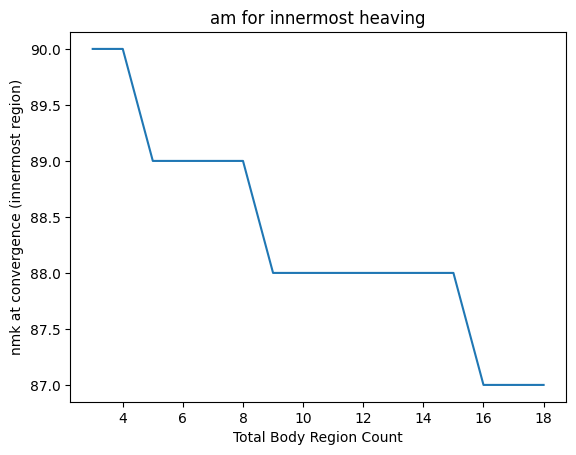

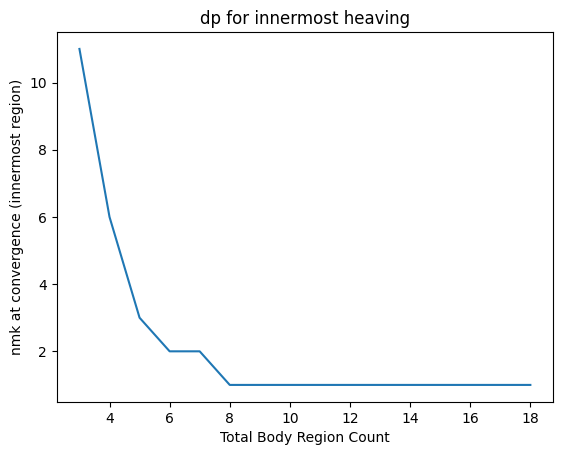

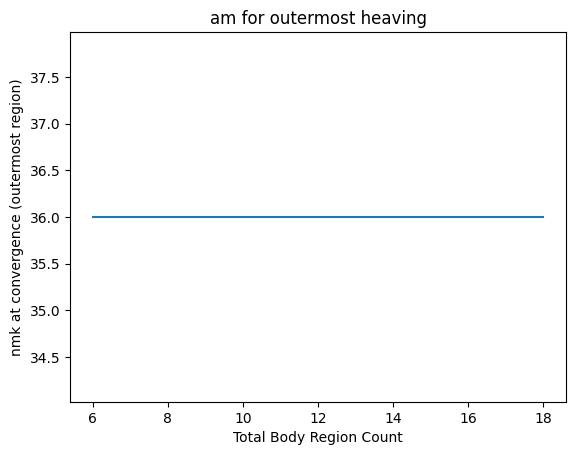

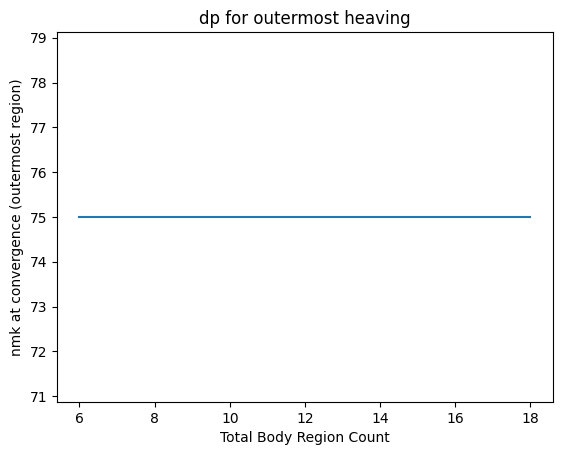

In [23]:
subset1 = all_inner_convergence_sets[0]
subset2 = all_outer_convergence_sets[0]

def plot_region_count_dependency(data, hydro, region_name):
  xs = []
  ys = []
  for data_dict in data:
    xs.append(data_dict["total body region count"])
    ys.append(data_dict[data_dict["m0s"][0]]["convergence point 0.01 " + hydro])
  plt.plot(xs, ys)
  plt.xlabel("Total Body Region Count")
  plt.ylabel("nmk at convergence (" + region_name + " region)")
  plt.title(hydro + " for " + region_name + " heaving")
  plt.show()

plot_region_count_dependency(subset1, "am", "innermost")
plot_region_count_dependency(subset1, "dp", "innermost")
plot_region_count_dependency(subset2, "am", "outermost")
plot_region_count_dependency(subset2, "dp", "outermost")